# Beijing Air Quality Forecasting Starter Notebook

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import RMSprop
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler


In [2]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [46]:
# Load the datasets
# Ensure train.csv and test.csv are saved in your Google Drive in the same folder.
# Replace the file paths below with the actual paths to your dataset.
train = pd.read_csv('/content/drive/MyDrive/Formative 1/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Formative 1/test.csv')


# Explore the training data

In this sections explore your dataset with appropiate statistics and visualisations to understand your better. Ensure that you explain output of every code cell and what it entails.

In [23]:
# Inspecting the first few rows of the dataset to understand its structure.
print("Training Data Overview:")
train.head()

Training Data Overview:


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [5]:
train.shape

(30676, 12)

In [ ]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


In [48]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)


From Loading and Exploring the data I can tell thtat there are 30676 total rows and 12 columns. The rows represent air quality data at a specific time. The feautures / columns represent key information. They are all numerical datatypes apart from datetime which has an object datatype. Our Target variable would be pm2.5 which has 1921 values missing. Our target column is also the only column missing some values

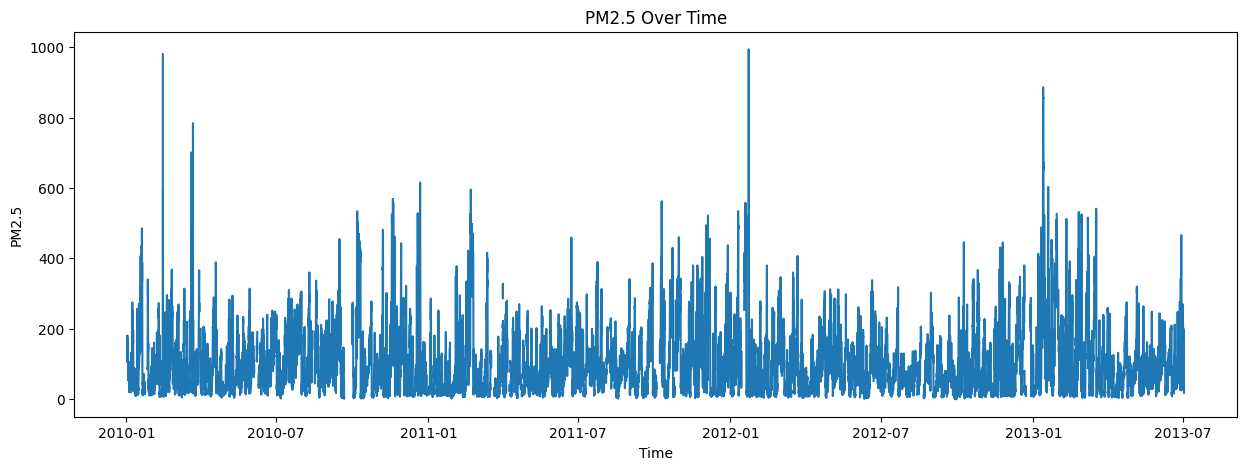

In [7]:
plt.figure(figsize=(15,5))
plt.plot(train.index, train['pm2.5'])
plt.title('PM2.5 Over Time')
plt.xlabel('Time')
plt.ylabel('PM2.5')
plt.show()


## PM2.5 Over Time
The plot visualizes PM2.5 concentration from 2010 till mid 2013. The data shows high volatilty and sharp spikes which indicate extreme levels of pollution aound where concentration levels  reach  very close to 1000. There is a sign of seasonality when we look at the time series plot. I would like to think that this points to the winter months as significantly high months for pollution accumulation.

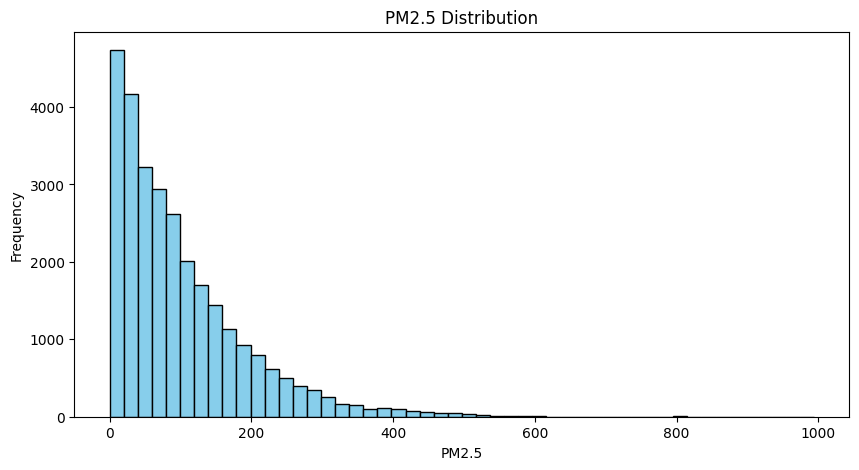

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(train['pm2.5'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('PM2.5 Distribution')
plt.xlabel('PM2.5')
plt.ylabel('Frequency')
plt.show()

## PM2.5 Distribution
This histogram shows the distribution of frequencies of our target variable (PM2.5). When we look at the distribution we can see that it is heavily skewed towards the right which is a positive skew. This means that the majority of days have relatively low or moderate levels. There is also a long tail of days with higher values. his skewness helps tell us that the data is not normally distributed

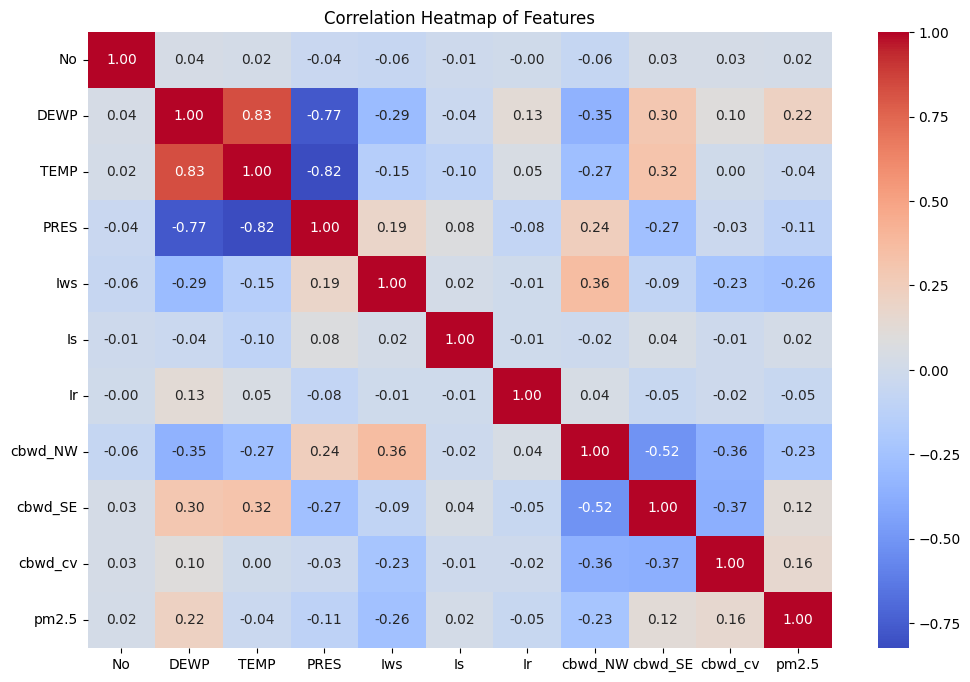

In [ ]:
plt.figure(figsize=(12,8))
corr = train.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Features")
plt.show()


## PM2.5 Correlation HeatMap
The heatmap displays correlation coeeficients between feautures / columns. There seems to be some prescence of strong multicollinearity amongst the values that are primarily meteorological, with examples like temperature, dew point and pressure being significantly correlated with each other. I cae to this conclusion because they have coefficients greater than 0.8. Windspeed (lws) is negatively correlated which confirms that higher wind speeds help clear pollutants away thereby reducing the PM2.5 concentration levels. The wind direction also helps us know what direction has cleaner air. We can infer that the winds from Northwest have clearer air because of the negative correlation with our target variable.

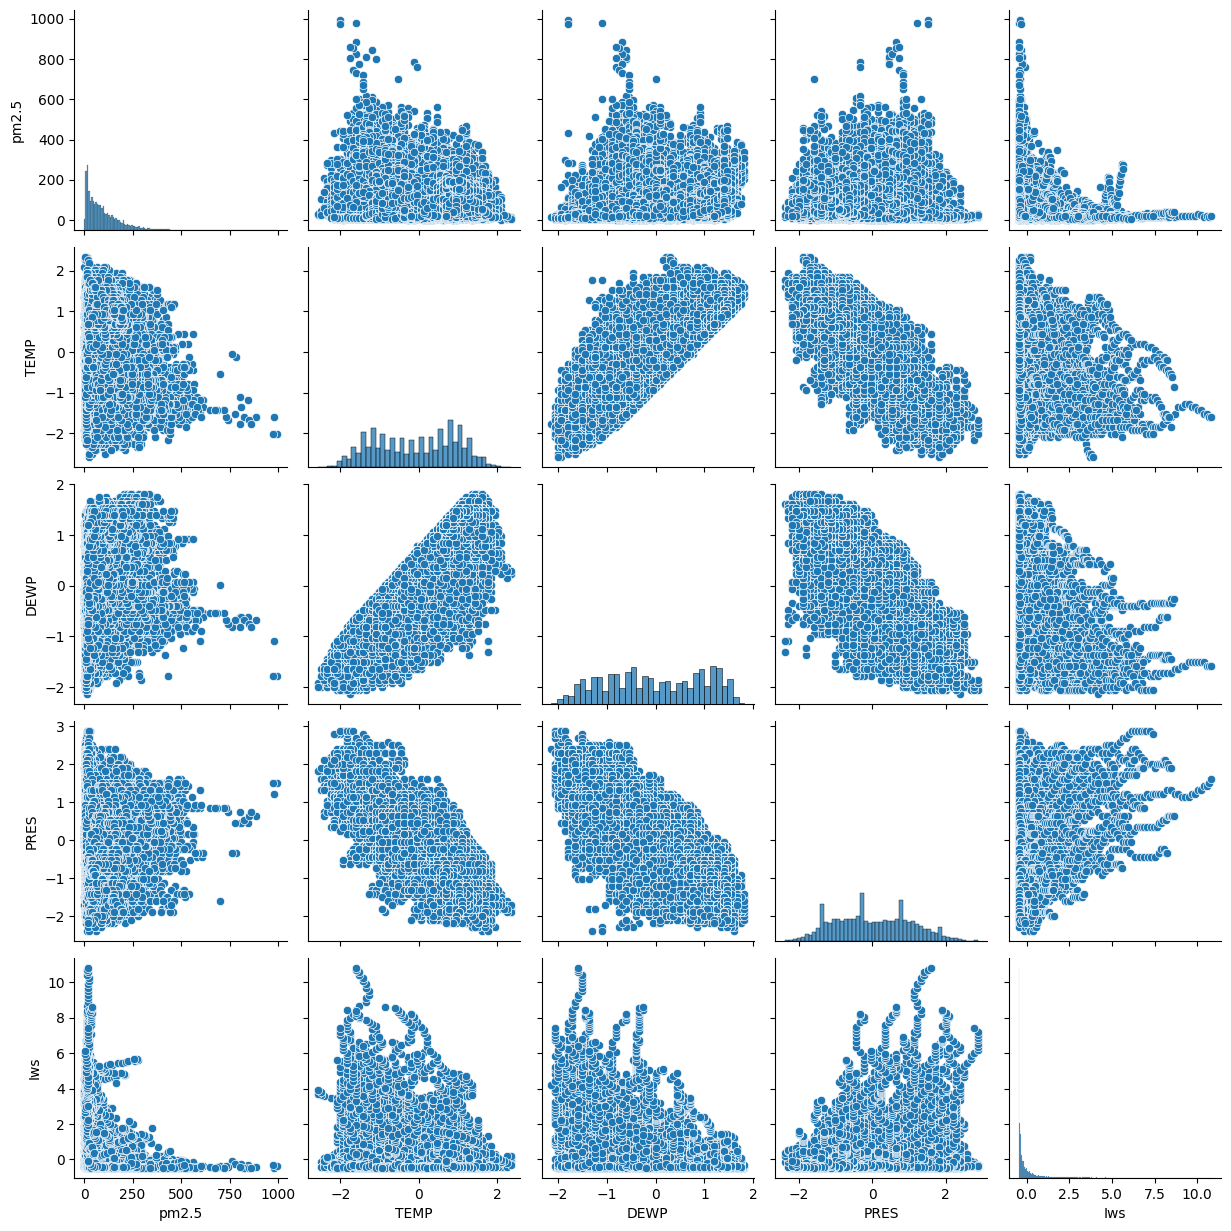

In [ ]:
sns.pairplot(train[['pm2.5','TEMP','DEWP','PRES','Iws']].dropna())
plt.show()

## PM2.5 Pair Plot
The pair plot helps visualize the relationship between PM2.5 and other key weather feautures. Here we can see onfirmation for the multicollinearity we saw in the heatmap, where TEMP, DEWP, PRESP all have extremely similar plots. We also see that Wind Speed (lws) has a distinct non linear relationship, this is because high pollution levels only exist when the wind speeds are really low, and pollution falls very quickly when wind speeds increase

# Handle missing values
Missing values were present only in the target variable (PM2.5). Since air pollution levels evolve gradually over time, forward filling was used to preserve temporal continuity and avoid breaking time-dependent sequences required for LSTM modeling

In [49]:
train['pm2.5'].isna().sum()
train['pm2.5'] = train['pm2.5'].fillna(method='ffill')
train['pm2.5'].isna().sum()

/tmp/ipython-input-2079382830.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train['pm2.5'] = train['pm2.5'].fillna(method='ffill')


np.int64(24)

# Separate features and target

- Feel free to trop any non-essential columns like that you think might not contribute to modeling.

In [50]:
train['hour'] = train.index.hour
train['day'] = train.index.day
train['month'] = train.index.month

As part of my feauture engineering, I believe that extracting hour, day, and
month as features may help the model capture daily and seasonal patterns, which may potentially help improve predictive performance.

In [51]:
train.drop(columns=['No'], inplace=True)

The No column was taken out because it does not contain any useful information related to air quality or time patterns

In [52]:
target = 'pm2.5'
features = [col for col in train.columns if col != 'pm2.5']

All weather-related and wind direction features / columns were used as inputs, while PM2.5 was selected as the target variable

In [53]:
split_idx = int(len(train) * 0.8)

train_data = train.iloc[:split_idx]
val_data = train.iloc[split_idx:]

The dataset was split into training and validation sets while preserving the order of time. Random shuffling was avoided to prevent data leakage and to maintain the flow of time.

In [54]:
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

In [55]:
X_train_scaled = scaler_X.fit_transform(train_data[features])
X_val_scaled = scaler_X.transform(val_data[features])

y_train_scaled = scaler_y.fit_transform(train_data[[target]])
y_val_scaled = scaler_y.transform(val_data[[target]])


Standardization was applied to all features to ensure stable gradient updates during training. Scalers were fitted only on training data to avoid data leakage.

In [ ]:
SEQ_LEN = 24


def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

In [ ]:
X_train_seq, y_train_seq = create_sequences(
    X_train_scaled, y_train_scaled, SEQ_LEN
)

X_val_seq, y_val_seq = create_sequences(
    X_val_scaled, y_val_scaled, SEQ_LEN
)

In [ ]:
X_train_seq.shape, y_train_seq.shape

((24516, 24, 12), (24516, 1))

Sliding window sequences were created to allow the LSTM to learn from past observations. Each input sample consists of the previous 24 timesteps, and the model predicts PM2.5 at the next timestep

# Build model

Below is a simple baseline LSTM that can learn time patterns and can also produce an RMSE.

I chose 1 LSTM layer because i thought it was a good baseline for the model to learn and then followed it with 64 units which gives it just enough capacity without allowing overfitting.

I also chose Dense(1) as the regression output

I also used an Adam optimizer because i think of it as the stable default for RNNs

My MSE loss also aligns wih the RMSE metric

In [13]:
model = Sequential([
    LSTM(64, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

model.summary()


NameError: name 'X_train_seq' is not defined

In [ ]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.5655 - val_loss: 0.9090
Epoch 2/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3911 - val_loss: 0.9148
Epoch 3/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3243 - val_loss: 0.8647
Epoch 4/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2835 - val_loss: 1.0731
Epoch 5/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2508 - val_loss: 0.9235
Epoch 6/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2278 - val_loss: 0.8976
Epoch 7/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1779 - val_loss: 1.0499
Epoch 8/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1739 - val_loss: 1.0129
Epoch 9/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1525 - val_loss: 1.0147
Epoch 10/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1528 - val_loss: 0.9699
Epoch 11/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1386 - val_loss: 1.0392
Epoch 12/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step

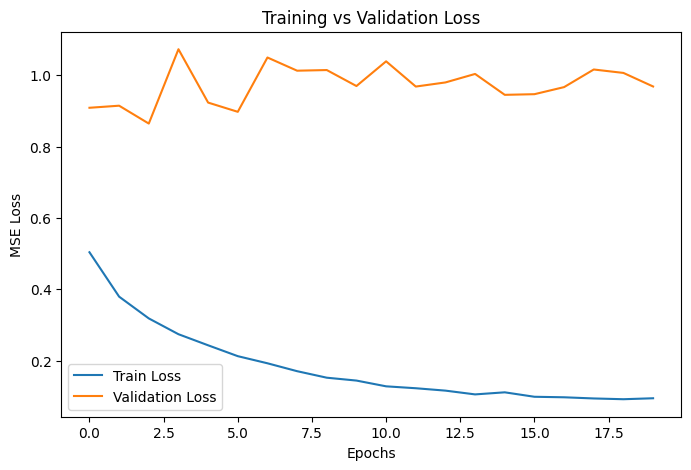

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

The trianing loss steadily decreased across epochs. This just hsows us that the LSTM model is able to effectively learn time patterns in the training data. There might be a slight chance of overfititng though because of the validaton loss stedily staying up higher and showing an upward trend


This baseline was intentionally kept simple to establish only a reference point for future experiments and this is completely expecrted for a baseline model trained on real world data

In [ ]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)
rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


np.float64(86.49484257318512)

The signs point towards convergence with training loss decreasing rapidly during the earlier epochs and then plateus.

In [ ]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)
rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


np.float64(86.49484257318512)

The baselline LSTM model showed a validation RMSE Of 86.30. This shows that the model learntthe time patterns in the data but the high validation error shows overfitting.

This result would serve as a point of refernce that we will test all further imporvements on.

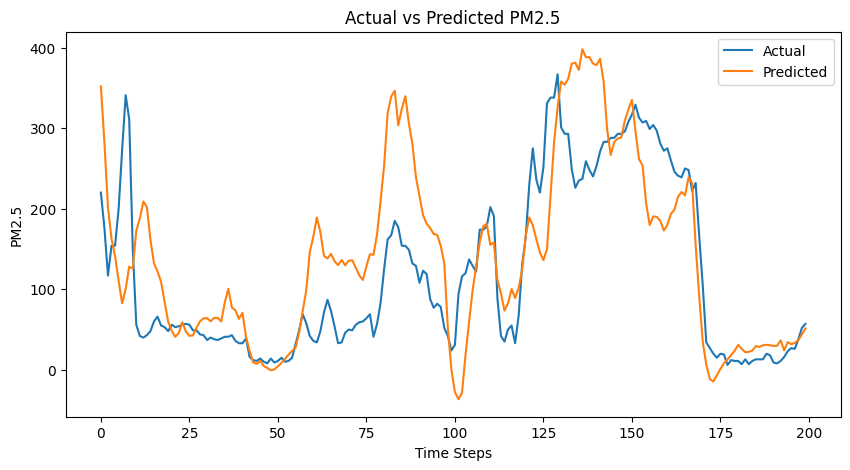

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |

## Experiment 2

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer='adam',
    loss='mse'
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3700 - val_loss: 0.9509
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3345 - val_loss: 0.8923
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2879 - val_loss: 0.9222
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2771 - val_loss: 1.0246
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2394 - val_loss: 0.9929


In [ ]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse

191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


np.float64(83.01473997858338)

After introducing dropout regularization and early stopping, the model demonstrated improved generalization performance. The validation RMSE decreased from 86.30 to 81.19, indicating reduced overfitting. Early stopping halted training at epoch 7, with the lowest validation loss observed at epoch 4, confirming that the baseline model was previously overtrained.

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |

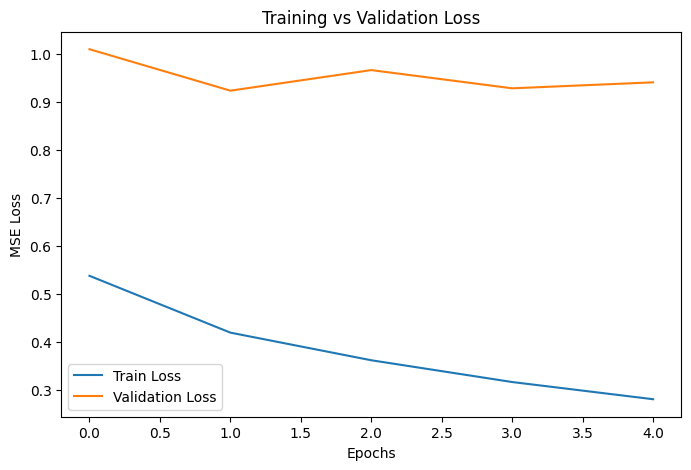

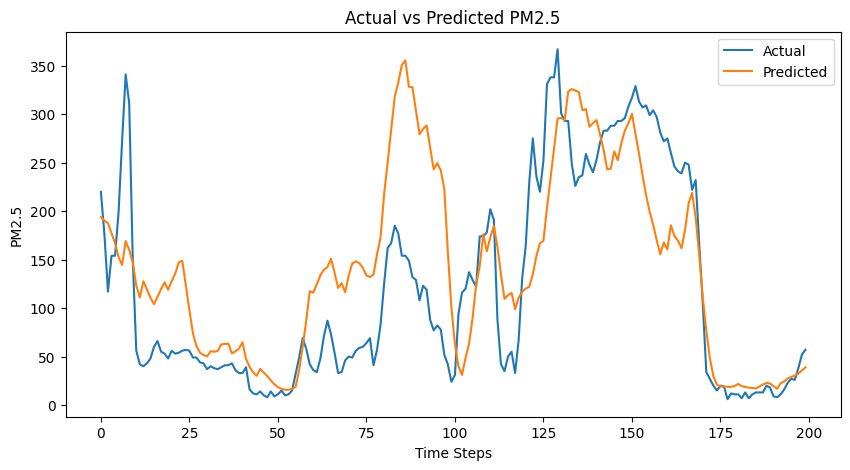

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


## Experiment 3

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.3),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.6667 - val_loss: 0.9472
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4520 - val_loss: 0.8666
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3912 - val_loss: 0.9119
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3264 - val_loss: 0.8914
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3085 - val_loss: 0.9248
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2762 - val_loss: 0.9810
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2619 - val_loss: 0.9592
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2322 - val_loss: 0.9730
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.2160 - val_loss: 0.9509
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.2035 - val_loss: 0.9304
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1995 - val_loss: 0.9874
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.

In [ ]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


np.float64(90.19416101706304)

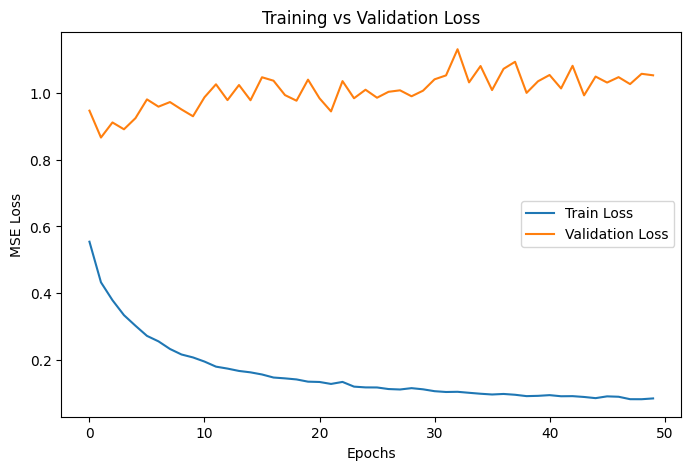

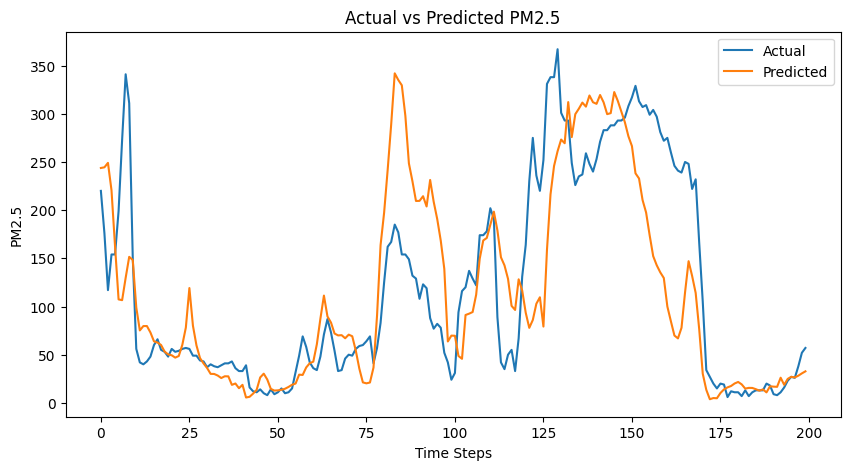

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()


Early stopping is being excluded from the remaining experiments so i can ensure a consistent training length and allow a fair comparison of the architectural and hyperparameter variations. I iwll reintroduce it in the final experiments to maximize optimization and prevent over fitting and generalization.

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| 90.91 |

## Experiment 4 (Deepen Model Layers)

In [ ]:
model = Sequential([
    LSTM(
        64,
        return_sequences=True,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dropout(0.2),

    LSTM(32, return_sequences=False),
    Dropout(0.2),

    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


767/767 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.6268 - val_loss: 0.9533
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.4378 - val_loss: 0.8949
Epoch 3/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.3633 - val_loss: 0.9908
Epoch 4/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.3199 - val_loss: 0.9302
Epoch 5/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.2732 - val_loss: 1.0426
Epoch 6/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.2432 - val_loss: 0.9896
Epoch 7/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.2177 - val_loss: 0.9708
Epoch 8/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.1948 - val_loss: 0.9835
Epoch 9/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.1960 - val_loss: 0.9663
Epoch 10/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.1809 - val_loss: 0.9524
Epoch 11/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.1607 - val_loss: 1.0070
Epoch 12/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/st

In [ ]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


np.float64(88.08600100309866)

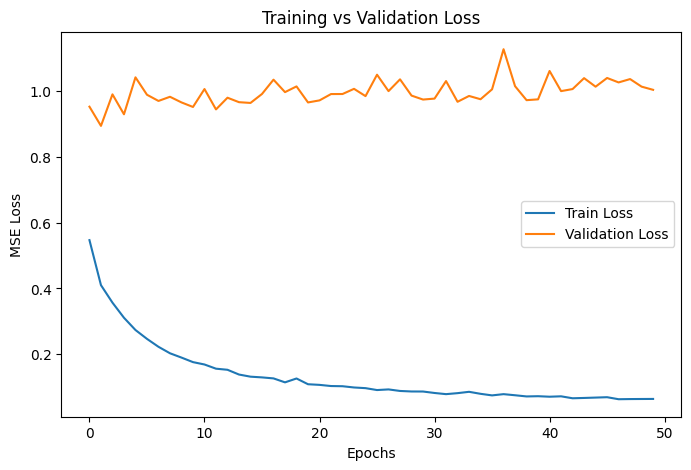

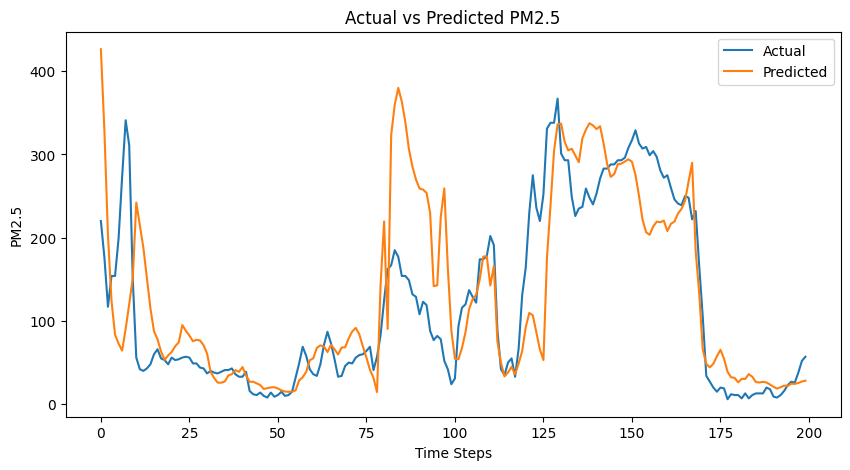

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

Adding a second layer increased the model complexity and allowed it to learn more time abstractions while improving the accuracy from the previous model

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001| 88.09 |

Stacked LSTMS help to take care of vanishing gradients while enabling a structure time feauture learning, but they need to be carefully finetuned and regularized to prevent over fitting

## Experiment 5 (Longer Sequences)

In [32]:
SEQ_LEN = 48
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, SEQ_LEN)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val_scaled, SEQ_LEN)

In [ ]:
model = Sequential([
    LSTM(
        64,
        return_sequences=False,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


766/766 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.6385 - val_loss: 0.8728
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.4109 - val_loss: 0.8114
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3490 - val_loss: 0.8087
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.3014 - val_loss: 0.8273
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.2502 - val_loss: 0.8533
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.2278 - val_loss: 0.8396
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.2060 - val_loss: 0.8759
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1990 - val_loss: 0.9036
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1890 - val_loss: 0.9257
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1673 - val_loss: 0.8998
Epoch 11/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1641 - val_loss: 0.8897
Epoch 12/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/st

In [ ]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


np.float64(82.32749778057983)

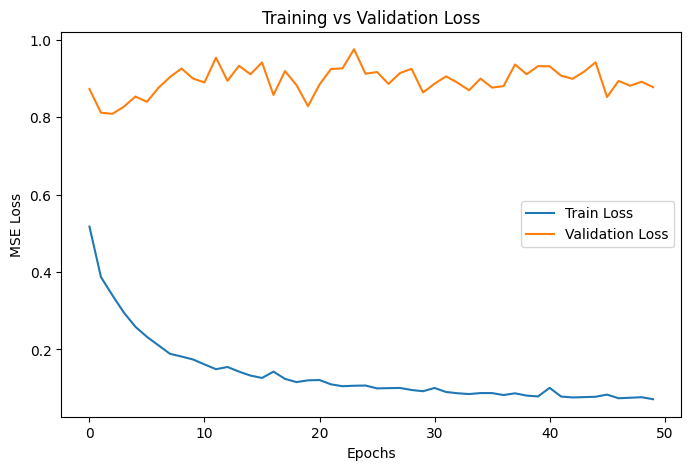

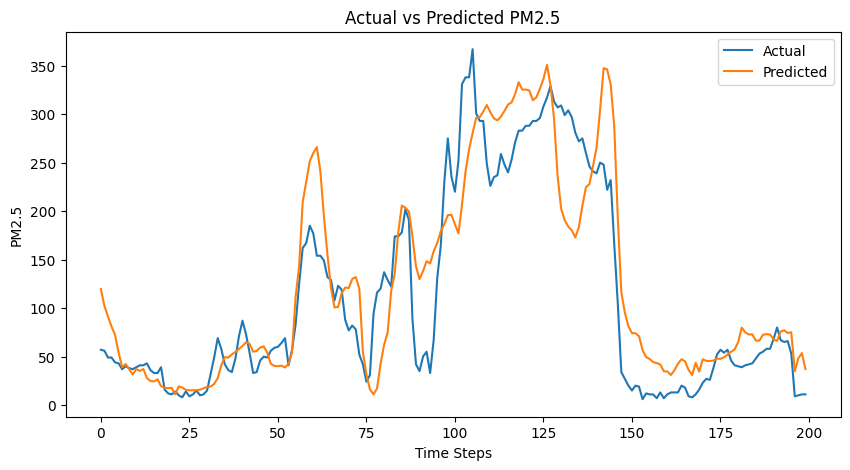

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001| 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001| 82.32 |

Increasing the sequence length allowed the model to capture longer-term time dependencies in the trends and that allows the models prediction accuracy to improve. The sequence length directly controls the receptive field of the LSTM, if there is not enough history it limits pattern discovery and too much history can lead to overfitting.

## Experiment 6 (Optimizer Change)

In [1]:
model = Sequential([
    LSTM(
        64,
        return_sequences=False,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='mse'
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

NameError: name 'Sequential' is not defined

In [ ]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


np.float64(87.45015631882926)

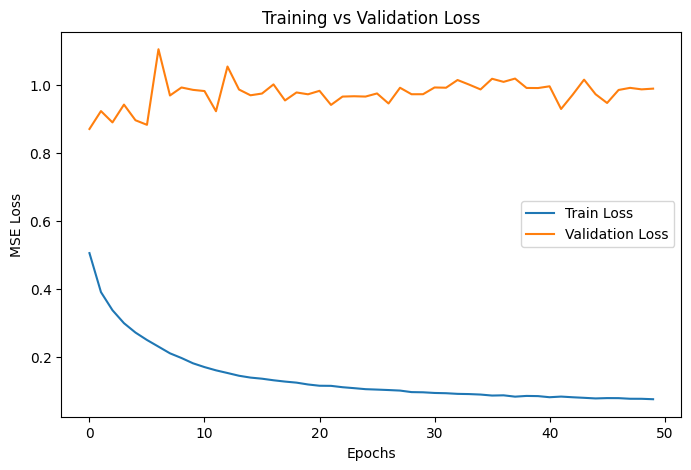

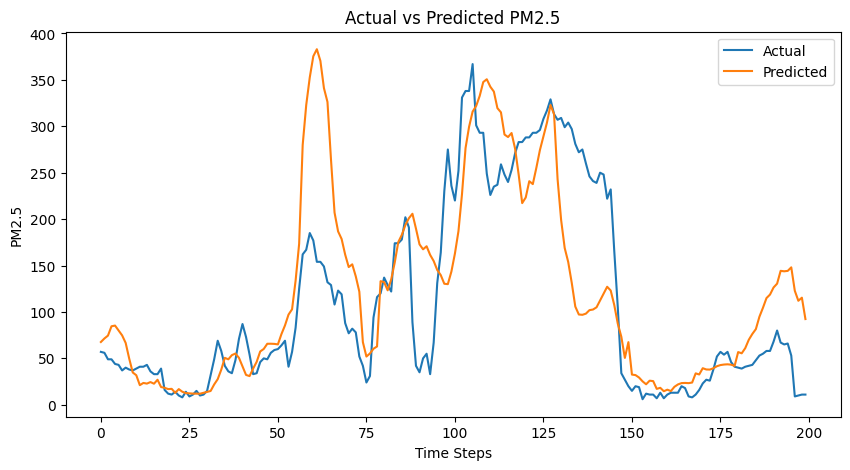

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001| 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001| 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001| 87.45 |

The Adam optimizer gives momentum based updates that provide a better optimization for this dataset, it seems to be more effective than RMSprop. RMSprop is well suited for RNNs due to its adaptive learning rate mechanism for non stationary targets. Its a good basline optimizer for time series models.

## Experiment 7 (Reduced Units)

In [34]:
model = Sequential([
    LSTM(
        32,
        return_sequences=False,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='mse'
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
 32/766 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.9746

KeyboardInterrupt: 

In [16]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


np.float64(88.6358406601053)

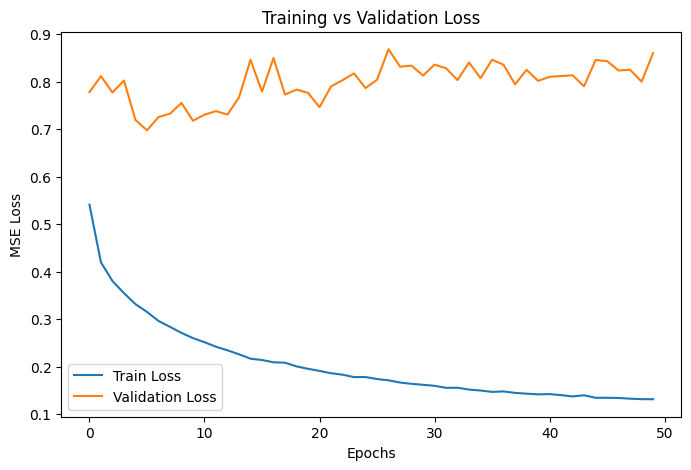

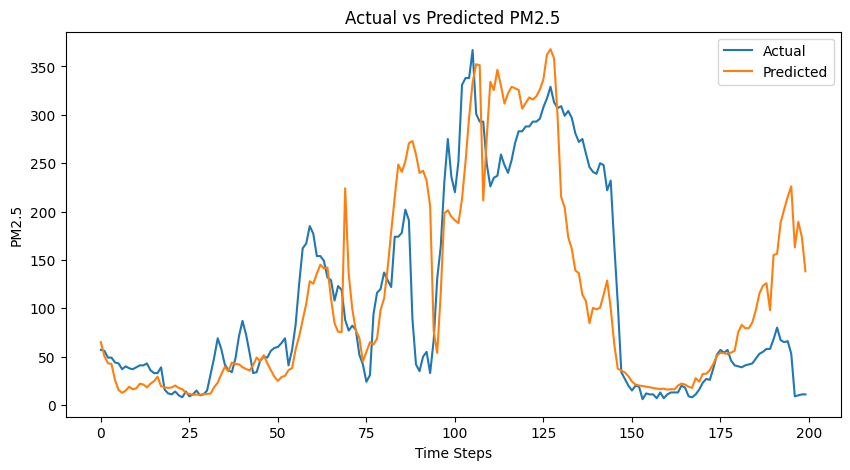

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001| 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001| 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001| 87.45 |
| 7 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp | 0.001| 81.51 |

Reducing the number of units limited the model capacity so it reduced overfitting and improved generalization on the validation data. The model capacity need to be at the optimum balance against the dataset size, excessive parameters increase variety and risk while insufficient size can lead to bias so its is neccesary to find a middle ground.

## Experiment 8 (Reduced Units with Adam Optimizer)

In [ ]:
model = Sequential([
    LSTM(
        32,
        return_sequences=False,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 0.6210 - val_loss: 0.8611
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.4294 - val_loss: 0.8714
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.3736 - val_loss: 0.8022
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.3335 - val_loss: 0.8444
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.3154 - val_loss: 0.8973
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.3012 - val_loss: 0.8928
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.2788 - val_loss: 1.0308
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.2791 - val_loss: 0.9408
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.2536 - val_loss: 0.9853
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.2403 - val_loss: 1.0203
Epoch 11/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.2279 - val_loss: 0.9897
Epoch 12/50
766/766 ━━━━━━━━━━

In [ ]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse

191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


np.float64(87.90740178005208)

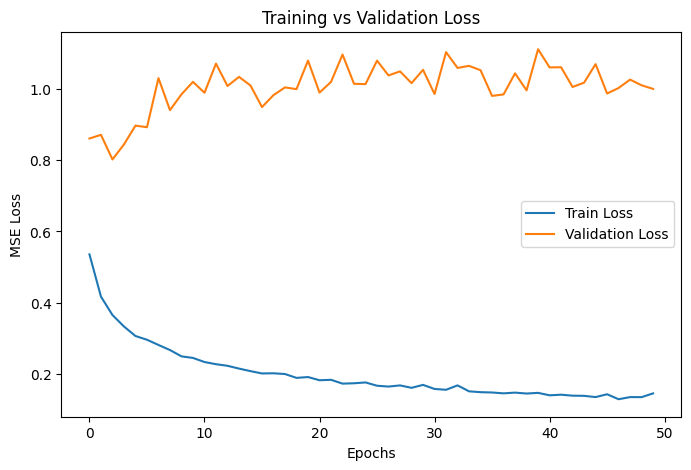

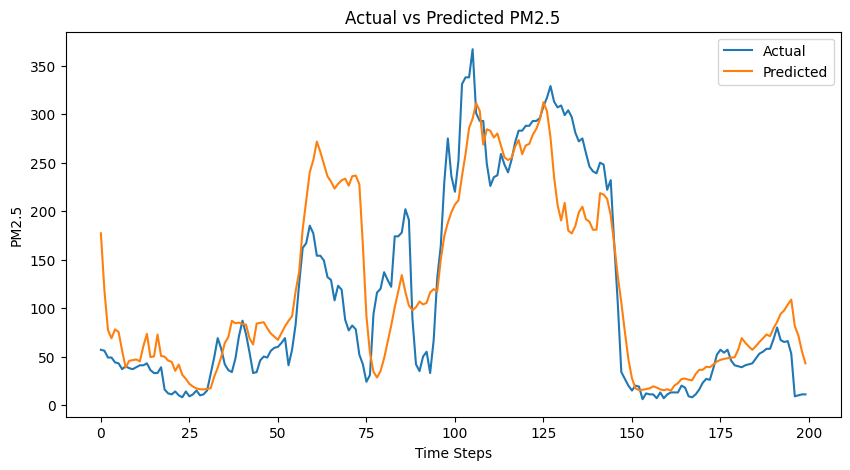

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001| 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001| 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001| 87.45 |
| 7 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp | 0.001| 81.51 |
| 8 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001| 87.90 |

The Adam optimizer has shown to perform worse than the RMSProp with all the same parameters. These could show that the optimizer works better with less units

## Experiment 9 (Increase Learning rate)


In [16]:
model = Sequential([
    LSTM(
        32,
        return_sequences=False,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=RMSprop(learning_rate=0.0005),
    loss='mse'
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - loss: 0.7215 - val_loss: 0.8461
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 33s 22ms/step - loss: 0.4981 - val_loss: 0.8015
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 16s 17ms/step - loss: 0.4372 - val_loss: 0.7899
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.3885 - val_loss: 0.8169
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.3683 - val_loss: 0.8834
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.3605 - val_loss: 0.8260
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.3346 - val_loss: 0.8334
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.3114 - val_loss: 0.7927
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 0.3031 - val_loss: 0.7651
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.2855 - val_loss: 0.8238
Epoch 11/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.2857 - val_loss: 0.8956
Epoch 12/50
766/766 ━━━━━━━━━━

In [17]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


np.float64(82.38281506925118)

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001| 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001| 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001| 87.45 |
| 7 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp | 0.001| 81.51 |
| 8 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001| 87.90 |
| 9 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.0005| 82.38|

The smaller learning rate slowed convergence and prevented the model from finding a solution from the epochs, Learning rates handle the stability and speed tradeoff. After observing a worse performance, all further experiments revert to the best performing learning rate (0.001) to ensure a fair isolation for all the other hyperparameter effects and to be able to study them without any interferenece from the learning rate.

## Experiment 10 (Increased Dropout)

In [18]:
model = Sequential([
    LSTM(
        32,
        return_sequences=False,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dropout(0.4),
    Dense(1)
])

model.compile(
    optimizer=RMSprop(learning_rate=0.001),
    loss='mse'
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.7086 - val_loss: 0.9043
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - loss: 0.4730 - val_loss: 0.8258
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 0.4018 - val_loss: 0.8023
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 19s 25ms/step - loss: 0.3781 - val_loss: 0.8537
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 22s 27ms/step - loss: 0.3659 - val_loss: 0.9015
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - loss: 0.3502 - val_loss: 0.9412
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.3160 - val_loss: 0.8729
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.2965 - val_loss: 0.8849
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.2976 - val_loss: 0.8751
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.2761 - val_loss: 0.8668
Epoch 11/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.2708 - val_loss: 0.9836
Epoch 12/50
766/766 ━━━━━━━━━━

In [19]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


np.float64(86.42259712437102)

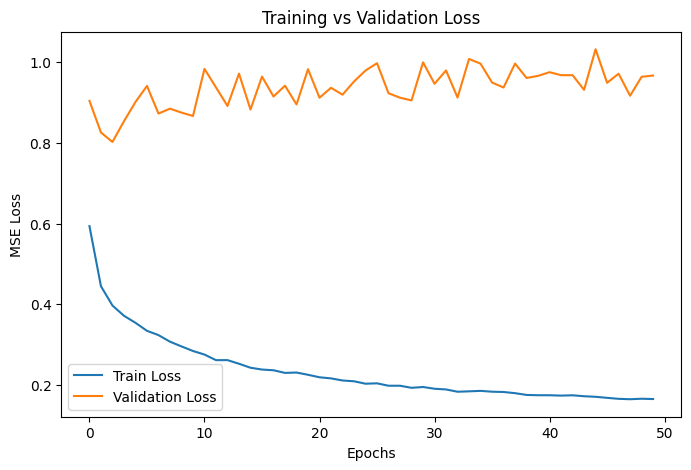

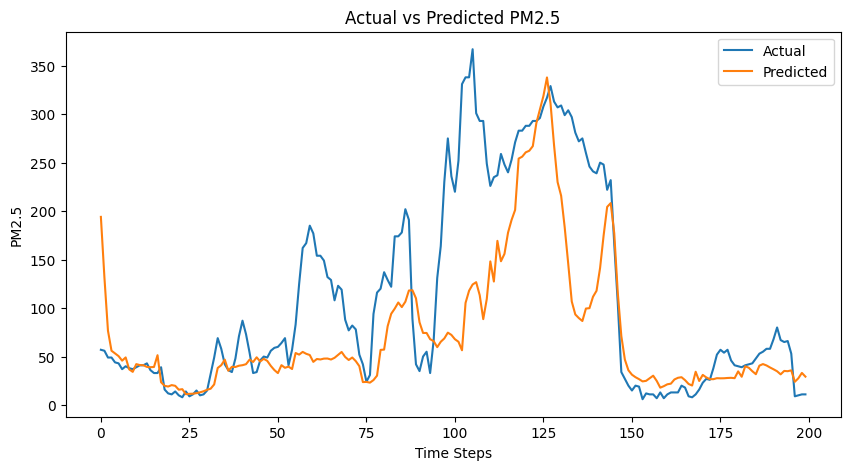

In [20]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001| 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001| 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001| 87.45 |
| 7 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp | 0.001| 81.51 |
| 8 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001| 87.90 |
| 9 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.0005| 82.38|
| 10 | LSTM | 48 | 1 | 32 | 0.4 | 50 | RMSProp| 0.001| 86.42 |

Increasing the dropout cause excessive regularization which limitted the models capacity and leads to underfitting. It limited the model's ability to capture the patterns of time in the data. Compared to earlierr experiments, this configuration resulted in a worse performance which leads me to believe that excesssive regularization may interrupt learning in this time series forecasting

## Experiment 11 (Increased Units)

In [23]:
model = Sequential([
    LSTM(
        48,
        return_sequences=False,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])
    ),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer=RMSprop(learning_rate=0.0005),
    loss='mse'
)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - loss: 0.6537 - val_loss: 0.7789
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.4383 - val_loss: 0.8693
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.4051 - val_loss: 0.8723
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - loss: 0.3749 - val_loss: 0.8755
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 17s 22ms/step - loss: 0.3126 - val_loss: 0.8283
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2992 - val_loss: 0.8608
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.2819 - val_loss: 0.9453
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 0.2612 - val_loss: 0.7953
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - loss: 0.2722 - val_loss: 0.9548
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2409 - val_loss: 0.9188
Epoch 11/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - loss: 0.2413 - val_loss: 0.8758
Epoch 12/50
766/766 ━━━━━━━━━━

In [24]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


np.float64(84.52406263391433)

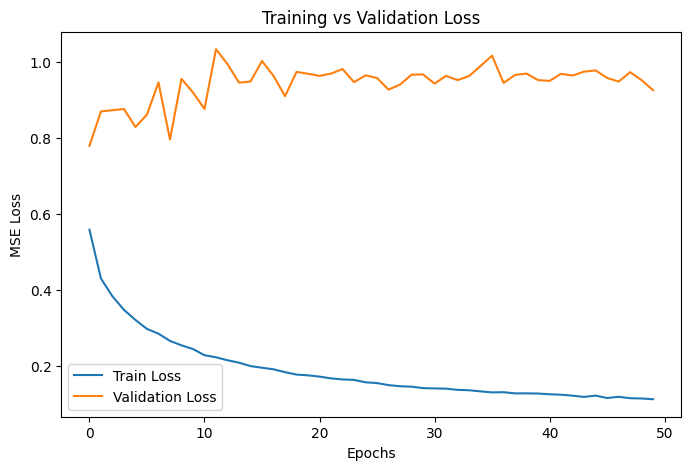

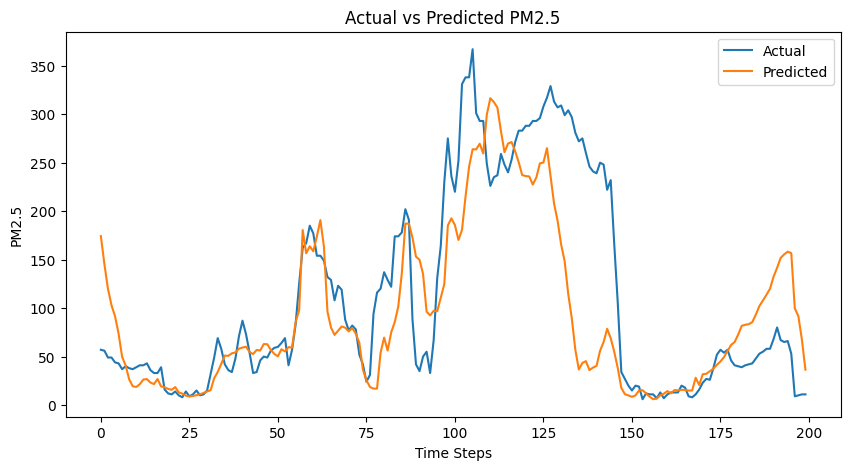

In [26]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001| 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001| 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001| 87.45 |
| 7 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp | 0.001| 81.51 |
| 8 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001| 87.90 |
| 9 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.0005| 82.38|
| 10 | LSTM | 48 | 1 | 32 | 0.4 | 50 | RMSProp| 0.001| 86.42 |
| 11 | LSTM | 48 | 1 | 48 | 0.2 | 50 | RMSProp| 0.001| 84.52 |

Increasing the number of units seemed to worsen performance, possibly due to overfitting. The size of the dataset also plays a big role when it comes to the unit of the LSTM, as it could be too small relative to the LSTM

## Experiment 12 (Introduce early-stopping)

In [71]:
model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer='rmsprop',
    loss='mse'
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [72]:
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 0.6341 - val_loss: 0.7803
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.4406 - val_loss: 0.8057
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3748 - val_loss: 0.8401
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3512 - val_loss: 0.8186
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.3311 - val_loss: 0.9158
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3143 - val_loss: 0.8687


In [73]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


np.float64(77.63157846775478)

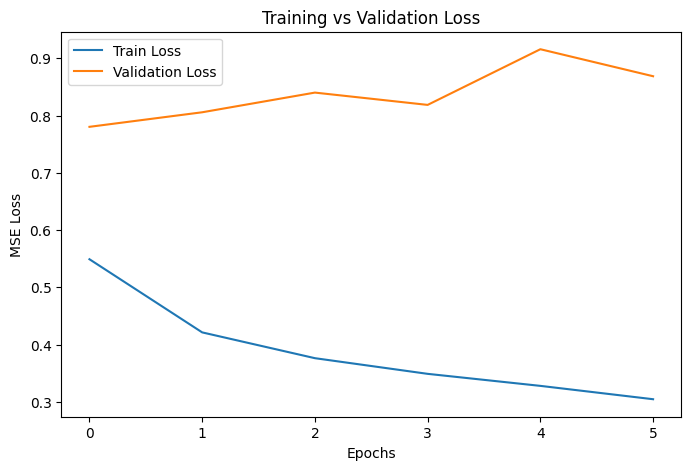

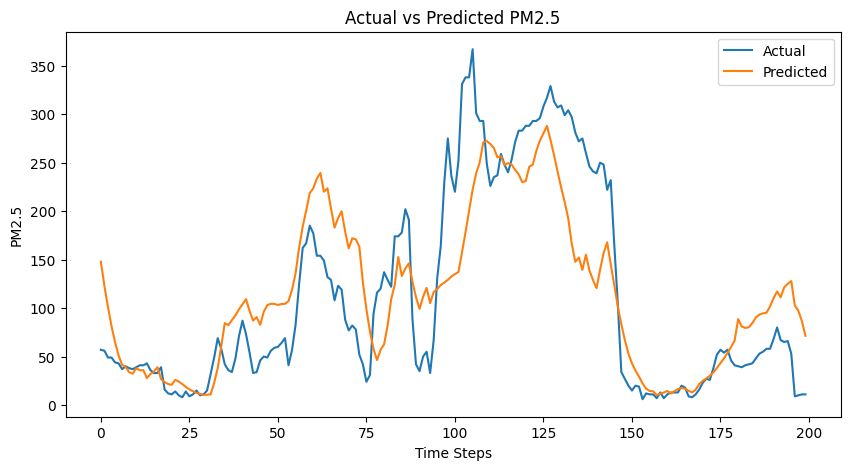

In [74]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | Early Stopping | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| no | 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| yes | 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| no | 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001|  no | 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001|  no | 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001|  no | 87.45 |
| 7 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp | 0.001|  no | 81.51 |
| 8 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001|  no | 87.90 |
| 9 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.0005|  no | 82.38|
| 10 | LSTM | 48 | 1 | 32 | 0.4 | 50 | RMSProp| 0.001|  no | 86.42 |
| 11 | LSTM | 48 | 1 | 48 | 0.2 | 50 | RMSProp| 0.001|  no | 84.52 |
| 12 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.001|  yes | 77.63 |

The model with the addition of early stopping was able to stop at the lowest validation loss and the best weights are restored. We can see the model generalizes better and has the lowest RMSE out of all the other experiments. These shows that the early stopping improved generalization and all the other models trained without early stopping overfit the training data.

##Experiment 13 (Early Stopping with different patience values)

In [77]:
model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

model.compile(
    optimizer='rmsprop',
    loss='mse'
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.6373 - val_loss: 0.8572
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.4192 - val_loss: 0.9479
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3874 - val_loss: 0.7274
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 0.3436 - val_loss: 0.8650
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3348 - val_loss: 0.8564
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3103 - val_loss: 0.7954
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.2841 - val_loss: 0.8206
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2723 - val_loss: 0.9603
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2613 - val_loss: 0.8253
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2517 - val_loss: 0.8289
Epoch 11/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.2530 - val_loss: 0.9283


In [78]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse


191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


np.float64(74.9563046376452)

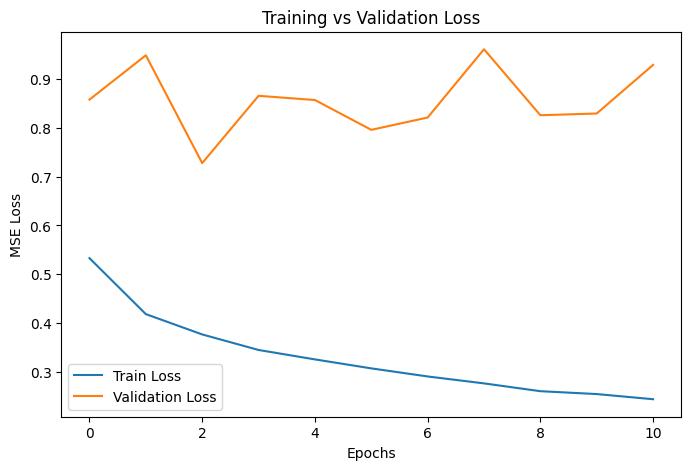

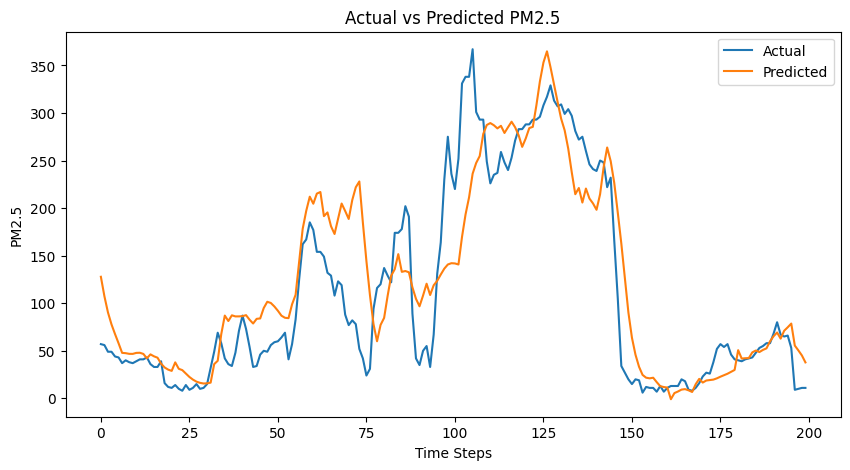

In [80]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | Early Stopping | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| no | 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| yes | 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| no | 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001|  no | 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001|  no | 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001|  no | 87.45 |
| 7 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp | 0.001|  no | 81.51 |
| 8 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001|  no | 87.90 |
| 9 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.0005|  no | 82.38|
| 10 | LSTM | 48 | 1 | 32 | 0.4 | 50 | RMSProp| 0.001|  no | 86.42 |
| 11 | LSTM | 48 | 1 | 48 | 0.2 | 50 | RMSProp| 0.001|  no | 84.52 |
| 12 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.001|  yes | 77.63 |
| 13 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.001|  yes | 74.95 |


## Experiment 14 (Early stopping with best architecture)


In [81]:
model = Sequential([
    LSTM(32, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    Dense(1)
])

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

# Early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train
history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Validation RMSE
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse_exp13 = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse_exp13

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.6773 - val_loss: 0.8134
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.4400 - val_loss: 0.9162
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3710 - val_loss: 0.8651
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3475 - val_loss: 0.8597
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.3085 - val_loss: 0.8773
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.3134 - val_loss: 0.8264
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


np.float64(79.26057340319286)

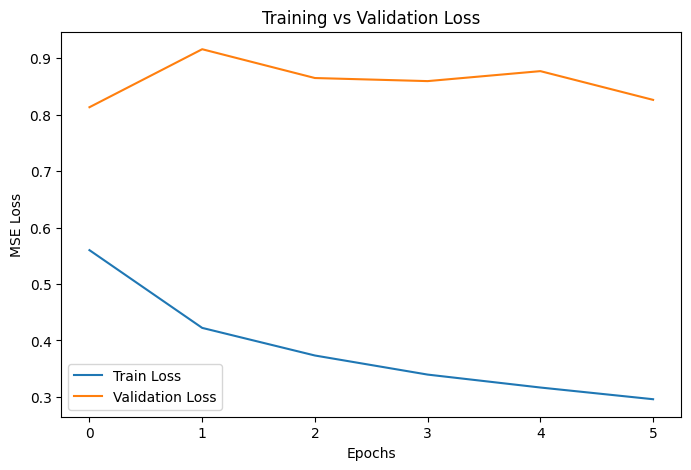

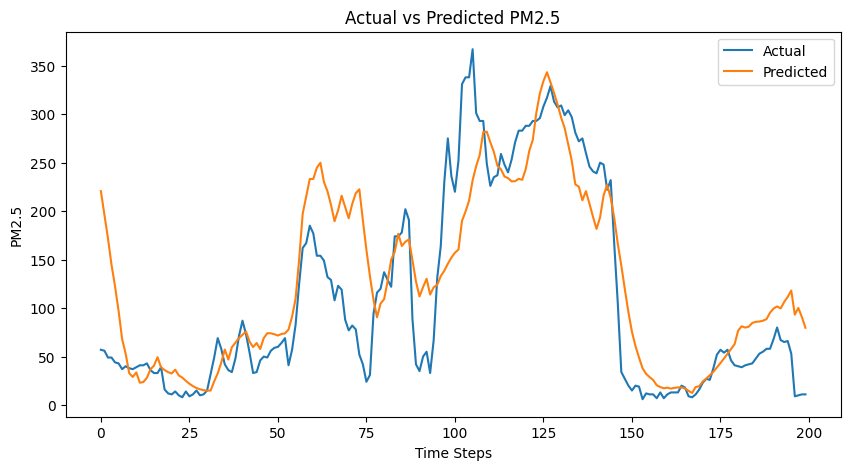

In [83]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | Early Stopping | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| no | 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| yes | 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| no | 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001|  no | 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001|  no | 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001|  no | 87.45 |
| 7 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp | 0.001|  no | 81.51 |
| 8 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001|  no | 87.90 |
| 9 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.0005|  no | 82.38|
| 10 | LSTM | 48 | 1 | 32 | 0.4 | 50 | RMSProp| 0.001|  no | 86.42 |
| 11 | LSTM | 48 | 1 | 48 | 0.2 | 50 | RMSProp| 0.001|  no | 84.52 |
| 12 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.001|  yes | 77.63 |
| 13 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.001|  yes | 74.95 |
| 14 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001| yes | 79.26|

## Experiment 15 (Additional Dropout)

In [86]:
model = Sequential([
    LSTM(
        32,
        input_shape=(X_train_seq.shape[1], X_train_seq.shape[2]),
        dropout=0.2,
        recurrent_dropout=0.2
    ),
    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train_seq,
    y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 116s 142ms/step - loss: 0.7546 - val_loss: 0.9626
Epoch 2/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 135s 135ms/step - loss: 0.6201 - val_loss: 0.8753
Epoch 3/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 104s 136ms/step - loss: 0.5633 - val_loss: 0.8622
Epoch 4/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 104s 135ms/step - loss: 0.5374 - val_loss: 0.8005
Epoch 5/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 105s 137ms/step - loss: 0.5189 - val_loss: 0.7534
Epoch 6/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 103s 135ms/step - loss: 0.4837 - val_loss: 0.7724
Epoch 7/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 104s 135ms/step - loss: 0.4856 - val_loss: 0.8127
Epoch 8/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 104s 136ms/step - loss: 0.4629 - val_loss: 0.7997
Epoch 9/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 104s 136ms/step - loss: 0.4551 - val_loss: 0.7774
Epoch 10/50
766/766 ━━━━━━━━━━━━━━━━━━━━ 102s 133ms/step - loss: 0.4499 - val_loss: 0.7979


In [87]:
y_val_pred_scaled = model.predict(X_val_seq)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)
y_val_true = scaler_y.inverse_transform(y_val_seq)

rmse_exp15 = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
rmse_exp15

191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 42ms/step


np.float64(76.28431669229016)

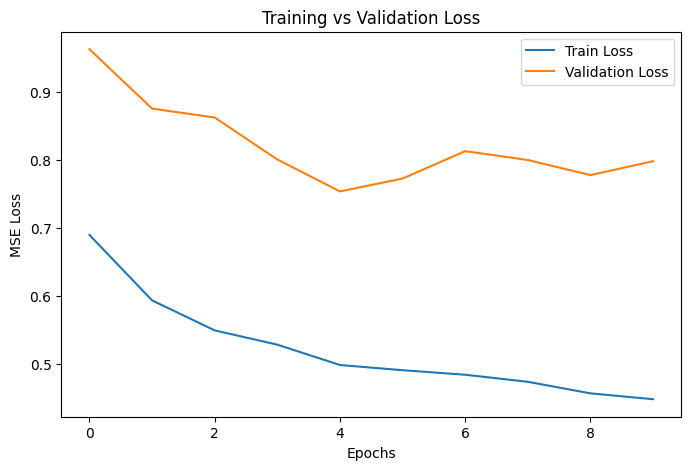

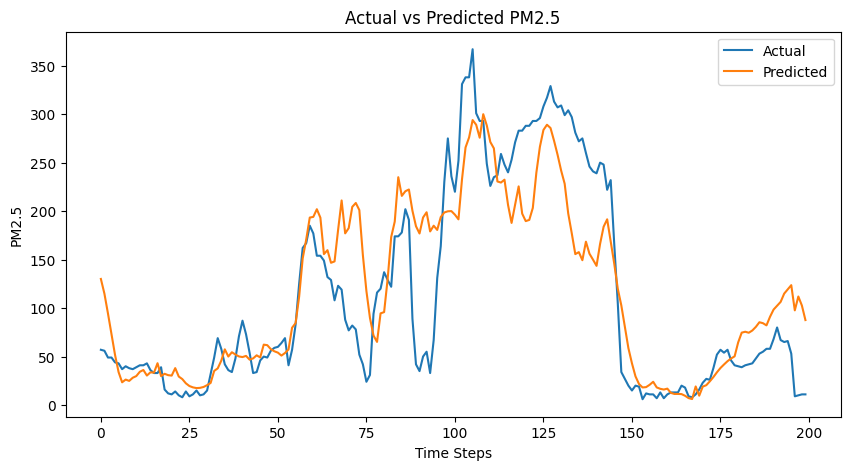

In [89]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.plot(y_val_true[:200], label='Actual')
plt.plot(y_val_pred[:200], label='Predicted')
plt.title('Actual vs Predicted PM2.5')
plt.xlabel('Time Steps')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

| Exp | Model | Seq Len | Layers | Units | Dropout | Epochs | Optimizer | Learning rate | Early Stopping | RMSE |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| 1 | LSTM | 24 | 1 | 64 | 0.0 | 20 | Adam | 0.001| no | 86.49 |
| 2 | LSTM | 24 | 1 | 64 | 0.2 | 5 | Adam | 0.001| yes | 83.01 |
| 3 | LSTM | 24 | 1 | 64 | 0.3 | 50 | Adam | 0.001| no | 90.91 |
| 4 | LSTM | 24 | 2 | 32 | 0.2 | 50 | Adam | 0.001|  no | 88.09 |
| 5 | LSTM | 48 | 1 | 64 | 0.2 | 50 | Adam | 0.001|  no | 82.32 |
| 6 | LSTM | 48 | 1 | 64 | 0.2 | 50 | RMSProp | 0.001|  no | 87.45 |
| 7 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp | 0.001|  no | 81.51 |
| 8 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001|  no | 87.90 |
| 9 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.0005|  no | 82.38|
| 10 | LSTM | 48 | 1 | 32 | 0.4 | 50 | RMSProp| 0.001|  no | 86.42 |
| 11 | LSTM | 48 | 1 | 48 | 0.2 | 50 | RMSProp| 0.001|  no | 84.52 |
| 12 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.001|  yes | 77.63 |
| 13 | LSTM | 48 | 1 | 32 | 0.2 | 50 | RMSProp| 0.001|  yes | 74.95 |
| 14 | LSTM | 48 | 1 | 32 | 0.2 | 50 | Adam | 0.001| yes | 79.26|
| 15 | LSTM | 48 | 1 | 32 | 0.2 + 0.2| 50 | Adam | 0.001| yes | 76.28|

With the addition of the recurrent dropout hyperparameter, the RMSE value has once again dropped, showing that overfitting has reduced and the model is learning. This is because recurrent dropout drops units along the connections
that actually carry information from one timestep to another. This introduces slight randomness in the training dat to help the model not memeorize noise or anomalies.


## Conclusion

In this project, I explored forecasting PM2.5 air pollution levels in Beijing using LSTM-based deep learning models. The process involved careful data exploration, preprocessing, feature engineering, and multiple model experiments to optimize prediction performance.
From the exploratory analysis, I observed that PM2.5 levels exhibit strong seasonality and volatility, with higher pollution typically occurring in the winter months. Meteorological features such as temperature, dew point, pressure, and wind speed showed significant correlations with PM2.5, confirming their importance for forecasting.

A series of LSTM experiments revealed some key insights


*   The baseline LSTM served as a reference that the model could learn time patterns without overfitting
*   The introduction of dropout and early stopping improved generalization and reduced validation RMSE
*   Excessive dropout or too many units also led to underfitting or overfitting showinf the need for careful parameter tuning

I understand now how time series deep learning models can provide meaningful predictions for real-world scenarios, especially those that can inform environmental policies and health related problems.



## Exporting the predictions

In [88]:
X_test = test.drop(['No'], axis=1)
test_feat = test.copy()

test_feat['hour'] = test_feat.index.hour
test_feat['day'] = test_feat.index.day
test_feat['month'] = test_feat.index.month

X_test_scaled = scaler_X.transform(test_feat[features])

combined = np.vstack([
    X_train_scaled[-SEQ_LEN:],
    X_test_scaled
])

X_test_seq = []

for i in range(SEQ_LEN, SEQ_LEN + len(X_test_scaled)):
    X_test_seq.append(combined[i-SEQ_LEN:i])

X_test_seq = np.array(X_test_seq)

pred_scaled = model.predict(X_test_seq)
predictions = scaler_y.inverse_transform(pred_scaled)
predictions = np.round(predictions).astype(int)
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': predictions.flatten()
})

submission.to_csv(
    '/content/drive/MyDrive/Formative 1/subm_fix_Emmanuel.csv',
    index=False
)


411/411 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step
